In [1]:
import pandas as pd
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split


from xgboost import XGBClassifier
from sklearn.preprocessing import Binarizer
from category_encoders import TargetEncoder
import warnings

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='NanumGothic'
%matplotlib inline 
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

In [2]:
def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [3]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
def target_encoder_app(cat, label, Df, Df2):
    i = 0
    l = len(cat)
    Df0 = pd.concat([Df,label], axis=1)
    for col in cat:
        encoder = TargetEncoder()
        encoder.fit(Df0[col], Df0["신청여부(타겟)"])
        Df[col] = encoder.transform(Df[col])
        Df2[col] = encoder.transform(Df2[col])
        i += 1
        print("{0}%만큼 완료".format(i*100/l))
    return Df, Df2

In [5]:
user_loan_train = pd.read_csv("./사용데이터/user_loan_train.csv", encoding = 'cp949')
user_loan_target = pd.read_csv("./사용데이터/user_loan_target.csv", encoding = 'cp949')
cluster_info = pd.read_csv("./사용데이터/cluster_result.csv", encoding = 'cp949')
bank_cluster_info = pd.read_csv("./사용데이터/bank_cluster_result.csv", encoding = 'cp949')
print(1)

user_loan_train = pd.merge(user_loan_train,cluster_info, left_on = '상품번호', right_on = '상품번호', how = 'inner')
user_loan_target = pd.merge(user_loan_target,cluster_info, left_on = '상품번호', right_on = '상품번호', how = 'inner')
print(2)

user_loan_train = pd.merge(user_loan_train,bank_cluster_info, left_on = '금융사번호', right_on = '금융사번호', how = 'inner')
user_loan_target = pd.merge(user_loan_target,bank_cluster_info, left_on = '금융사번호', right_on = '금융사번호', how = 'inner')
print(3)

1
2
3


## 월,일(시간)에 따른 총 신청횟수 비교
* 월/일이 영향을 주는지 판단

In [7]:
positive = user_loan_train[user_loan_train["신청여부(타겟)"] ==1]

In [9]:
positive = positive[["월","일","신청여부(타겟)"]]

In [14]:
positive2 = positive.groupby(["월","일"]).count()

<AxesSubplot:title={'center':'날짜별 신청횟수'}, xlabel='월,일'>

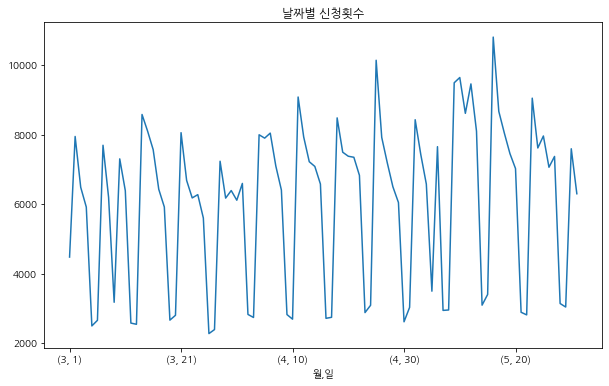

In [22]:
plt.figure(figsize = (10,6))
plt.title("날짜별 신청횟수")
positive2["신청여부(타겟)"].plot()

## 파생변수 추가

**추천상품수추가**

In [6]:
count_df1 = user_loan_train[["신청서번호","월"]]
count_df2 = count_df1.groupby("신청서번호").count().reset_index()
count_df2.rename(columns = {"월": "추천상품수"}, inplace = True)
count_df2 = pd.merge(count_df1, count_df2, how = "left", left_on = "신청서번호", right_on = "신청서번호")
user_loan_train["추천상품수"]= count_df2["추천상품수"]

**최소금리여부추가**

In [7]:
ir_df = user_loan_train[["신청서번호","승인금리"]]
ir_min_df=pd.DataFrame(ir_df.groupby("신청서번호").min()).reset_index()
ir_min_df.rename(columns = {"승인금리":"승인금리최소"}, inplace = True)
ir_min_df = pd.merge(ir_df, ir_min_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
ir_min_df["최소금리여부"] = ir_min_df["승인금리"] == ir_min_df["승인금리최소"]
ir_min_df["최소금리여부"].replace({True:1, False :0}, inplace = True)
user_loan_train["최소금리여부"] = ir_min_df["최소금리여부"]

**추천 평균금리 추가**

In [8]:
ir_mean_df = pd.DataFrame(ir_df.groupby("신청서번호").mean()).reset_index()
ir_mean_df.rename(columns = {"승인금리":"승인금리평균"}, inplace = True)
ir_mean_df = pd.merge(ir_df, ir_mean_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
user_loan_train["승인금리평균"]= ir_mean_df["승인금리평균"]

**최대한도여부추가**

In [9]:
lm_df = user_loan_train[["신청서번호","승인한도"]]
lm_max_df=pd.DataFrame(lm_df.groupby("신청서번호").max()).reset_index()
lm_max_df.rename(columns = {"승인한도":"승인한도최대"}, inplace = True)
lm_max_df = pd.merge(lm_df, lm_max_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
lm_max_df["최대한도여부"] = lm_max_df["승인한도"] == lm_max_df["승인한도최대"]
lm_max_df["최대한도여부"].replace({True:1, False :0}, inplace = True)
user_loan_train["최대한도여부"] = lm_max_df["최대한도여부"]

**추천평균한도 추가**

In [10]:
lm_mean_df = pd.DataFrame(lm_df.groupby("신청서번호").mean()).reset_index()
lm_mean_df.rename(columns = {"승인한도":"승인한도평균"}, inplace = True)
lm_mean_df = pd.merge(lm_df, lm_mean_df, how = "left", left_on = "신청서번호", right_on = "신청서번호")
user_loan_train["승인한도평균"] = lm_mean_df["승인한도평균"]

## 시험삼아 시험지표 만들어봄(예측준비까지 클릭하지 말기)
* 오히려 안좋아짐
* 추천평균한도, 추천평균금리가 있는게 낫다. 아마도 알아서 판단해주는듯함

In [18]:
user_loan_train["시험지표"] = (user_loan_train["승인한도"]/user_loan_train["승인금리"]) - (user_loan_train["승인한도평균"]/user_loan_train["승인금리평균"])

In [20]:
user_loan_train[user_loan_train["신청서번호"] ==1945280][["시험지표","신청여부(타겟)"]]

,시험지표,신청여부(타겟)
260813,-2.497298e+06,0.0
701513,7.452958e+06,0.0
2008648,-2.290909e+06,0.0
2226290,2.931242e+05,0.0
2604852,1.897402e+06,0.0
2702785,-2.163204e+06,0.0
2925112,-9.499390e+05,0.0
3088063,-1.239602e+06,0.0
3969777,1.398265e+05,0.0
4153131,-2.470537e+06,0.0


In [21]:
user_loan_train["시험지표"].describe()

count    1.026439e+07
mean     1.499131e+05
std      1.992157e+06
min     -3.949774e+08
25%     -6.341404e+05
50%      0.000000e+00
75%      6.447349e+05
max      9.450208e+08
Name: 시험지표, dtype: float64

**승인금리평균, 승인한도평균 drop 해보기**

In [56]:
user_loan_train.drop(["승인금리평균","승인한도평균"], axis=1, inplace = True)

## 예측준비

In [11]:
y_for_train = user_loan_train["신청여부(타겟)"]

In [12]:
X_for_test = user_loan_train.drop(["생성일시","신청서번호", "유저번호","나이","금융사번호","상품번호","신청여부(타겟)"], axis = 1)
X_for_target = user_loan_target.drop(["생성일시","신청서번호", "유저번호","나이","금융사번호","상품번호","신청여부(타겟)"], axis = 1)

In [13]:
cat = ["근로형태","고용형태","주거소유형태","대출목적"]

In [14]:
X_for_test, X_for_target = target_encoder_app(cat, y_for_train, X_for_test, X_for_target)

25.0%만큼 완료
50.0%만큼 완료
75.0%만큼 완료
100.0%만큼 완료


In [15]:
prod = [0,1,2]
bank = [0,1,2,3]
rep = 'abcde'

In [16]:
for i in prod:
    X_for_test.replace({"상품군집":{i:rep[i]}}, inplace = True)

In [17]:
for i in bank:
    X_for_test.replace({"은행군집":{i:rep[i]}}, inplace = True)

In [18]:
cat2 = ["상품군집","은행군집"]

In [19]:
X_for_test, X_for_target = target_encoder_app(cat2, y_for_train, X_for_test, X_for_target)

50.0%만큼 완료
100.0%만큼 완료


### MinMaxScaler

In [20]:
minmax_x = MinMaxScaler()
minmax_x.fit(pd.concat([X_for_test,X_for_target]))

MinMaxScaler()

In [21]:
col = X_for_test.columns
X_for_test = pd.DataFrame(minmax_x.transform(X_for_test), columns = col)

### 예측에 사용된 최종 테이블

In [22]:
X_for_test.head(4)

,월,일,한도조회당시유저신용점수,연소득,근로형태,고용형태,주거소유형태,대출희망금액,대출목적,개인회생자여부,기대출수,기대출금액,승인한도,승인금리,상품군집,은행군집,추천상품수,최소금리여부,승인금리평균,최대한도여부,승인한도평균
0,0.333333,0.633333,0.640017,0.0050,0.693735,1.0,0.609171,0.0025,0.535261,0.0,0.013100,0.010117,0.000013,0.702703,0.0,0.00513,0.012821,1.0,0.848649,1.0,0.000400
1,0.333333,0.633333,0.702969,0.0095,0.000000,0.0,0.609171,0.0040,0.535261,0.0,0.017467,0.018903,0.000061,0.648649,0.0,0.00513,0.371795,0.0,0.630090,0.0,0.004335
2,0.333333,0.633333,0.713461,0.0050,0.777816,1.0,0.609171,0.0030,0.535261,0.0,0.013100,0.004925,0.000039,0.648649,0.0,0.00513,0.128205,0.0,0.677641,0.0,0.004359
3,0.333333,0.633333,0.776414,0.0030,0.000000,0.0,0.609171,0.0008,0.752258,0.0,0.017467,0.024494,0.000156,0.562162,0.0,0.00513,0.602564,0.0,0.582207,0.0,0.005402


In [23]:
X_for_test.columns

Index(['월', '일', '한도조회당시유저신용점수', '연소득', '근로형태', '고용형태', '주거소유형태', '대출희망금액',
       '대출목적', '개인회생자여부', '기대출수', '기대출금액', '승인한도', '승인금리', '상품군집', '은행군집',
       '추천상품수', '최소금리여부', '승인금리평균', '최대한도여부', '승인한도평균'],
      dtype='object')

### train_test_split

In [24]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_for_test, y_for_train,
                                         test_size=0.2, random_state=156, stratify = y_for_train)

In [25]:
# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리  
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train,
                                         test_size=0.1, random_state=156, stratify = y_train )

## XGBoost

**grid search cv를 쓰려고 했으나 메모리 문제로 성공하지 못했다. 하나하나씩 튜닝해보자**

In [26]:
xgb_wrapper = XGBClassifier(n_estimators=1000, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 2)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)


xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65449	validation_1-logloss:0.65453
[1]	validation_0-logloss:0.61944	validation_1-logloss:0.61952
[2]	validation_0-logloss:0.58755	validation_1-logloss:0.58766
[3]	validation_0-logloss:0.55839	validation_1-logloss:0.55854
[4]	validation_0-logloss:0.53168	validation_1-logloss:0.53185
[5]	validation_0-logloss:0.50710	validation_1-logloss:0.50731
[6]	validation_0-logloss:0.48444	validation_1-logloss:0.48466
[7]	validation_0-logloss:0.46353	validation_1-logloss:0.46378
[8]	validation_0-logloss:0.44418	validation_1-logloss:0.44446
[9]	validation_0-logloss:0.42621	validation_1-logloss:0.42651
[10]	validation_0-logloss:0.40953	validation_1-logloss:0.40986
[11]	validation_0-logloss:0.39402	validation_1-logloss:0.39436
[12]	validation_0-logloss:0.37956	validation_1-logloss:0.37992
[13]	validation_0-logloss:0.36609	validation_1-logloss:0.36646
[14]	validation_0-logloss:0.35351	validation_1-logloss:0.35391
[15]	validation_0-logloss:0.34178	validation_1-logloss:0.34220
[1

[130]	validation_0-logloss:0.14728	validation_1-logloss:0.14838
[131]	validation_0-logloss:0.14721	validation_1-logloss:0.14831
[132]	validation_0-logloss:0.14716	validation_1-logloss:0.14826
[133]	validation_0-logloss:0.14709	validation_1-logloss:0.14820
[134]	validation_0-logloss:0.14702	validation_1-logloss:0.14814
[135]	validation_0-logloss:0.14698	validation_1-logloss:0.14809
[136]	validation_0-logloss:0.14693	validation_1-logloss:0.14805
[137]	validation_0-logloss:0.14687	validation_1-logloss:0.14799
[138]	validation_0-logloss:0.14683	validation_1-logloss:0.14795
[139]	validation_0-logloss:0.14678	validation_1-logloss:0.14791
[140]	validation_0-logloss:0.14673	validation_1-logloss:0.14787
[141]	validation_0-logloss:0.14668	validation_1-logloss:0.14782
[142]	validation_0-logloss:0.14664	validation_1-logloss:0.14778
[143]	validation_0-logloss:0.14660	validation_1-logloss:0.14774
[144]	validation_0-logloss:0.14656	validation_1-logloss:0.14770
[145]	validation_0-logloss:0.14651	valid

[259]	validation_0-logloss:0.14436	validation_1-logloss:0.14575
[260]	validation_0-logloss:0.14435	validation_1-logloss:0.14574
[261]	validation_0-logloss:0.14434	validation_1-logloss:0.14574
[262]	validation_0-logloss:0.14434	validation_1-logloss:0.14573
[263]	validation_0-logloss:0.14433	validation_1-logloss:0.14572
[264]	validation_0-logloss:0.14431	validation_1-logloss:0.14571
[265]	validation_0-logloss:0.14430	validation_1-logloss:0.14570
[266]	validation_0-logloss:0.14429	validation_1-logloss:0.14569
[267]	validation_0-logloss:0.14428	validation_1-logloss:0.14569
[268]	validation_0-logloss:0.14427	validation_1-logloss:0.14568
[269]	validation_0-logloss:0.14426	validation_1-logloss:0.14568
[270]	validation_0-logloss:0.14426	validation_1-logloss:0.14567
[271]	validation_0-logloss:0.14424	validation_1-logloss:0.14566
[272]	validation_0-logloss:0.14423	validation_1-logloss:0.14565
[273]	validation_0-logloss:0.14423	validation_1-logloss:0.14565
[274]	validation_0-logloss:0.14422	valid

[388]	validation_0-logloss:0.14322	validation_1-logloss:0.14487
[389]	validation_0-logloss:0.14321	validation_1-logloss:0.14487
[390]	validation_0-logloss:0.14320	validation_1-logloss:0.14486
[391]	validation_0-logloss:0.14320	validation_1-logloss:0.14486
[392]	validation_0-logloss:0.14319	validation_1-logloss:0.14485
[393]	validation_0-logloss:0.14319	validation_1-logloss:0.14485
[394]	validation_0-logloss:0.14318	validation_1-logloss:0.14485
[395]	validation_0-logloss:0.14318	validation_1-logloss:0.14484
[396]	validation_0-logloss:0.14317	validation_1-logloss:0.14484
[397]	validation_0-logloss:0.14316	validation_1-logloss:0.14483
[398]	validation_0-logloss:0.14315	validation_1-logloss:0.14482
[399]	validation_0-logloss:0.14315	validation_1-logloss:0.14482
[400]	validation_0-logloss:0.14314	validation_1-logloss:0.14481
[401]	validation_0-logloss:0.14313	validation_1-logloss:0.14481
[402]	validation_0-logloss:0.14312	validation_1-logloss:0.14480
[403]	validation_0-logloss:0.14311	valid

[517]	validation_0-logloss:0.14233	validation_1-logloss:0.14426
[518]	validation_0-logloss:0.14233	validation_1-logloss:0.14425
[519]	validation_0-logloss:0.14232	validation_1-logloss:0.14425
[520]	validation_0-logloss:0.14232	validation_1-logloss:0.14425
[521]	validation_0-logloss:0.14231	validation_1-logloss:0.14424
[522]	validation_0-logloss:0.14231	validation_1-logloss:0.14424
[523]	validation_0-logloss:0.14230	validation_1-logloss:0.14423
[524]	validation_0-logloss:0.14229	validation_1-logloss:0.14423
[525]	validation_0-logloss:0.14229	validation_1-logloss:0.14422
[526]	validation_0-logloss:0.14228	validation_1-logloss:0.14422
[527]	validation_0-logloss:0.14228	validation_1-logloss:0.14422
[528]	validation_0-logloss:0.14227	validation_1-logloss:0.14421
[529]	validation_0-logloss:0.14226	validation_1-logloss:0.14421
[530]	validation_0-logloss:0.14225	validation_1-logloss:0.14420
[531]	validation_0-logloss:0.14225	validation_1-logloss:0.14420
[532]	validation_0-logloss:0.14225	valid

[646]	validation_0-logloss:0.14162	validation_1-logloss:0.14378
[647]	validation_0-logloss:0.14161	validation_1-logloss:0.14378
[648]	validation_0-logloss:0.14161	validation_1-logloss:0.14378
[649]	validation_0-logloss:0.14160	validation_1-logloss:0.14378
[650]	validation_0-logloss:0.14159	validation_1-logloss:0.14377
[651]	validation_0-logloss:0.14158	validation_1-logloss:0.14376
[652]	validation_0-logloss:0.14158	validation_1-logloss:0.14376
[653]	validation_0-logloss:0.14158	validation_1-logloss:0.14376
[654]	validation_0-logloss:0.14157	validation_1-logloss:0.14376
[655]	validation_0-logloss:0.14156	validation_1-logloss:0.14375
[656]	validation_0-logloss:0.14156	validation_1-logloss:0.14375
[657]	validation_0-logloss:0.14155	validation_1-logloss:0.14375
[658]	validation_0-logloss:0.14155	validation_1-logloss:0.14374
[659]	validation_0-logloss:0.14154	validation_1-logloss:0.14374
[660]	validation_0-logloss:0.14154	validation_1-logloss:0.14373
[661]	validation_0-logloss:0.14153	valid

[775]	validation_0-logloss:0.14098	validation_1-logloss:0.14339
[776]	validation_0-logloss:0.14097	validation_1-logloss:0.14338
[777]	validation_0-logloss:0.14097	validation_1-logloss:0.14338
[778]	validation_0-logloss:0.14097	validation_1-logloss:0.14338
[779]	validation_0-logloss:0.14096	validation_1-logloss:0.14338
[780]	validation_0-logloss:0.14096	validation_1-logloss:0.14338
[781]	validation_0-logloss:0.14095	validation_1-logloss:0.14337
[782]	validation_0-logloss:0.14095	validation_1-logloss:0.14337
[783]	validation_0-logloss:0.14095	validation_1-logloss:0.14337
[784]	validation_0-logloss:0.14094	validation_1-logloss:0.14337
[785]	validation_0-logloss:0.14094	validation_1-logloss:0.14336
[786]	validation_0-logloss:0.14093	validation_1-logloss:0.14336
[787]	validation_0-logloss:0.14093	validation_1-logloss:0.14336
[788]	validation_0-logloss:0.14092	validation_1-logloss:0.14336
[789]	validation_0-logloss:0.14092	validation_1-logloss:0.14335
[790]	validation_0-logloss:0.14092	valid

[904]	validation_0-logloss:0.14042	validation_1-logloss:0.14307
[905]	validation_0-logloss:0.14041	validation_1-logloss:0.14307
[906]	validation_0-logloss:0.14041	validation_1-logloss:0.14306
[907]	validation_0-logloss:0.14041	validation_1-logloss:0.14306
[908]	validation_0-logloss:0.14040	validation_1-logloss:0.14306
[909]	validation_0-logloss:0.14040	validation_1-logloss:0.14306
[910]	validation_0-logloss:0.14040	validation_1-logloss:0.14306
[911]	validation_0-logloss:0.14039	validation_1-logloss:0.14305
[912]	validation_0-logloss:0.14039	validation_1-logloss:0.14305
[913]	validation_0-logloss:0.14039	validation_1-logloss:0.14305
[914]	validation_0-logloss:0.14038	validation_1-logloss:0.14305
[915]	validation_0-logloss:0.14038	validation_1-logloss:0.14305
[916]	validation_0-logloss:0.14038	validation_1-logloss:0.14305
[917]	validation_0-logloss:0.14037	validation_1-logloss:0.14304
[918]	validation_0-logloss:0.14037	validation_1-logloss:0.14304
[919]	validation_0-logloss:0.14037	valid

In [27]:
print(classification_report(xgb_preds, y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97   1956457
           1       0.41      0.47      0.44     96421

    accuracy                           0.94   2052878
   macro avg       0.69      0.72      0.70   2052878
weighted avg       0.95      0.94      0.95   2052878



In [28]:
get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

오차 행렬
[[1891019   50917]
 [  65438   45504]]
정확도: 0.9433, 정밀도: 0.4719, 재현율: 0.4102,    F1: 0.4389, AUC:0.9221


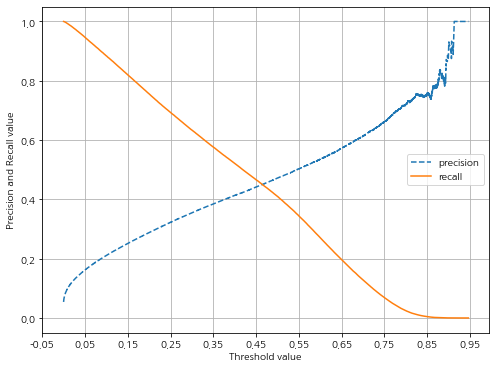

In [29]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

In [30]:
thresholds = [0.40,0.42, 0.45, 0.48]
pred_probas = xgb_pred_proba.reshape(-1,1)
for thres_val in thresholds:
    binarizer = Binarizer(threshold = thres_val).fit(pred_probas)
    new_pred = binarizer.transform(pred_probas)
    get_clf_eval(y_test , new_pred, pred_probas)
    print(classification_report(new_pred, y_test))

오차 행렬
[[1859877   82059]
 [  53089   57853]]
정확도: 0.9342, 정밀도: 0.4135, 재현율: 0.5215,    F1: 0.4612, AUC:0.9221
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96   1912966
         1.0       0.52      0.41      0.46    139912

    accuracy                           0.93   2052878
   macro avg       0.74      0.69      0.71   2052878
weighted avg       0.93      0.93      0.93   2052878

오차 행렬
[[1866708   75228]
 [  55586   55356]]
정확도: 0.9363, 정밀도: 0.4239, 재현율: 0.4990,    F1: 0.4584, AUC:0.9221
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97   1922294
         1.0       0.50      0.42      0.46    130584

    accuracy                           0.94   2052878
   macro avg       0.73      0.70      0.71   2052878
weighted avg       0.93      0.94      0.93   2052878

오차 행렬
[[1876518   65418]
 [  59226   51716]]
정확도: 0.9393, 정밀도: 0.4415, 재현율: 0.4662,    F1: 0.4535, AUC:0.9221
              pr

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

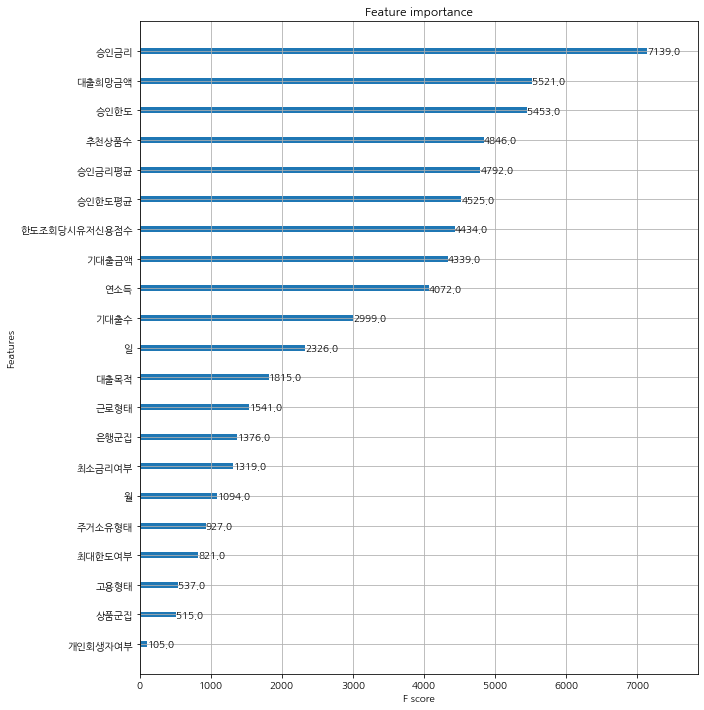

In [31]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

In [32]:
import shap
import skimage
import random
random.seed(0)

https://zzinnam.tistory.com/entry/SHAP-value%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%86%8C%EA%B0%9Cwith-Python

In [33]:
explainer = shap.TreeExplainer(xgb_wrapper)

In [34]:
x_shap = X_val.reset_index(drop=True)
idx = random.sample(range(821150), 200000)

In [35]:
shap_values = explainer(x_shap)

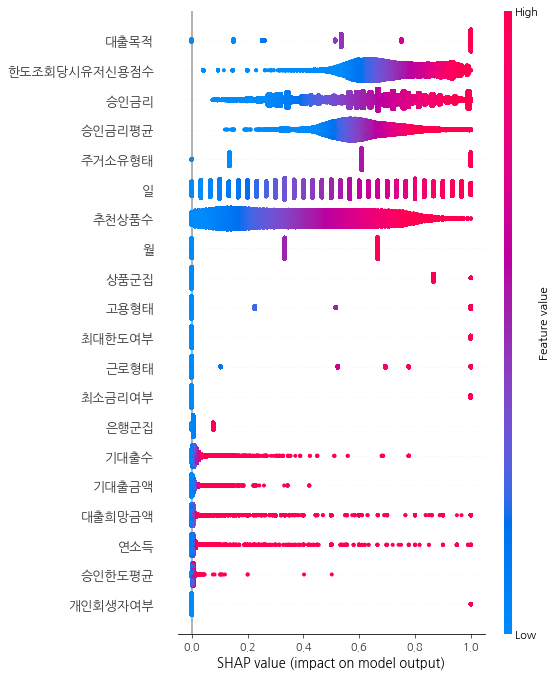

In [36]:
shap.summary_plot(shap_values.data, x_shap)

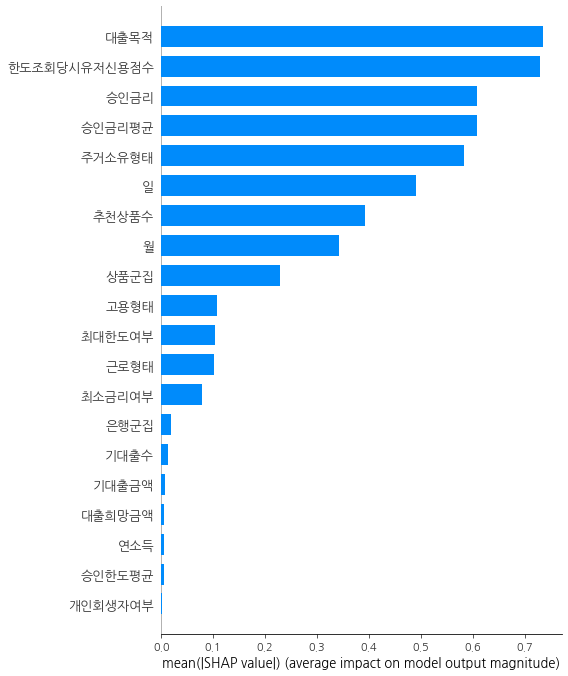

In [37]:
shap.summary_plot(shap_values.data, x_shap, plot_type = "bar")
#shap.summary_plot(shap_values, X_test, plot_type = "bar")

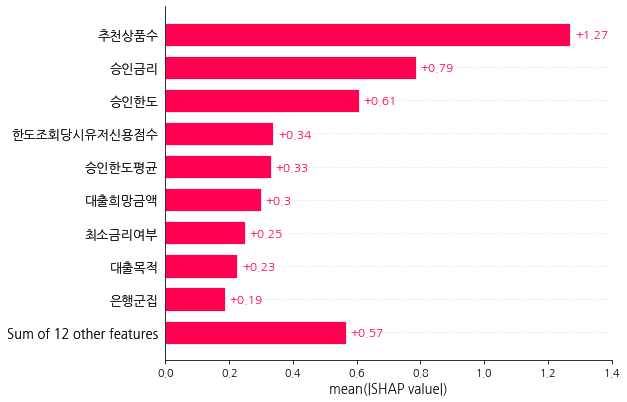

In [38]:
shap.plots.bar(shap_values)

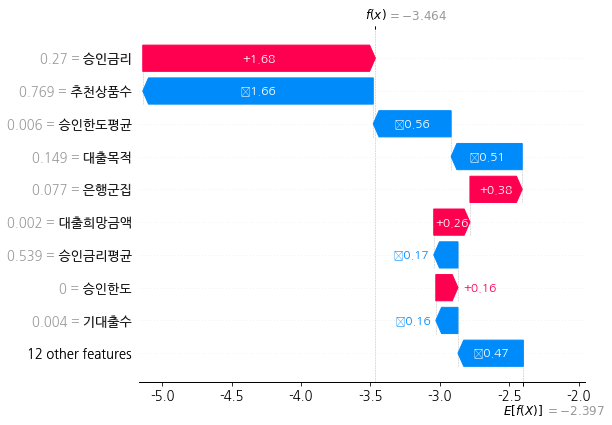

In [39]:
shap.plots.waterfall(shap_values[0])

In [40]:
xgb_wrapper = XGBClassifier(n_estimators=1000, learning_rate=0.03, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 1.6)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)


xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.66923	validation_1-logloss:0.66925
[1]	validation_0-logloss:0.64669	validation_1-logloss:0.64674
[2]	validation_0-logloss:0.62542	validation_1-logloss:0.62549
[3]	validation_0-logloss:0.60530	validation_1-logloss:0.60538
[4]	validation_0-logloss:0.58626	validation_1-logloss:0.58637
[5]	validation_0-logloss:0.56821	validation_1-logloss:0.56833
[6]	validation_0-logloss:0.55110	validation_1-logloss:0.55124
[7]	validation_0-logloss:0.53483	validation_1-logloss:0.53498
[8]	validation_0-logloss:0.51936	validation_1-logloss:0.51954
[9]	validation_0-logloss:0.50465	validation_1-logloss:0.50484
[10]	validation_0-logloss:0.49064	validation_1-logloss:0.49084
[11]	validation_0-logloss:0.47728	validation_1-logloss:0.47750
[12]	validation_0-logloss:0.46453	validation_1-logloss:0.46475
[13]	validation_0-logloss:0.45237	validation_1-logloss:0.45261
[14]	validation_0-logloss:0.44075	validation_1-logloss:0.44099
[15]	validation_0-logloss:0.42964	validation_1-logloss:0.42990
[1

[130]	validation_0-logloss:0.14980	validation_1-logloss:0.15064
[131]	validation_0-logloss:0.14957	validation_1-logloss:0.15042
[132]	validation_0-logloss:0.14936	validation_1-logloss:0.15021
[133]	validation_0-logloss:0.14914	validation_1-logloss:0.14999
[134]	validation_0-logloss:0.14894	validation_1-logloss:0.14979
[135]	validation_0-logloss:0.14873	validation_1-logloss:0.14959
[136]	validation_0-logloss:0.14854	validation_1-logloss:0.14940
[137]	validation_0-logloss:0.14835	validation_1-logloss:0.14921
[138]	validation_0-logloss:0.14817	validation_1-logloss:0.14903
[139]	validation_0-logloss:0.14798	validation_1-logloss:0.14885
[140]	validation_0-logloss:0.14781	validation_1-logloss:0.14867
[141]	validation_0-logloss:0.14764	validation_1-logloss:0.14850
[142]	validation_0-logloss:0.14746	validation_1-logloss:0.14833
[143]	validation_0-logloss:0.14731	validation_1-logloss:0.14818
[144]	validation_0-logloss:0.14715	validation_1-logloss:0.14802
[145]	validation_0-logloss:0.14699	valid

[259]	validation_0-logloss:0.14038	validation_1-logloss:0.14149
[260]	validation_0-logloss:0.14036	validation_1-logloss:0.14147
[261]	validation_0-logloss:0.14034	validation_1-logloss:0.14145
[262]	validation_0-logloss:0.14032	validation_1-logloss:0.14143
[263]	validation_0-logloss:0.14031	validation_1-logloss:0.14142
[264]	validation_0-logloss:0.14028	validation_1-logloss:0.14140
[265]	validation_0-logloss:0.14027	validation_1-logloss:0.14138
[266]	validation_0-logloss:0.14024	validation_1-logloss:0.14136
[267]	validation_0-logloss:0.14023	validation_1-logloss:0.14135
[268]	validation_0-logloss:0.14020	validation_1-logloss:0.14133
[269]	validation_0-logloss:0.14019	validation_1-logloss:0.14131
[270]	validation_0-logloss:0.14017	validation_1-logloss:0.14130
[271]	validation_0-logloss:0.14015	validation_1-logloss:0.14128
[272]	validation_0-logloss:0.14013	validation_1-logloss:0.14126
[273]	validation_0-logloss:0.14012	validation_1-logloss:0.14125
[274]	validation_0-logloss:0.14010	valid

[388]	validation_0-logloss:0.13887	validation_1-logloss:0.14014
[389]	validation_0-logloss:0.13886	validation_1-logloss:0.14013
[390]	validation_0-logloss:0.13886	validation_1-logloss:0.14013
[391]	validation_0-logloss:0.13885	validation_1-logloss:0.14012
[392]	validation_0-logloss:0.13885	validation_1-logloss:0.14012
[393]	validation_0-logloss:0.13884	validation_1-logloss:0.14011
[394]	validation_0-logloss:0.13883	validation_1-logloss:0.14011
[395]	validation_0-logloss:0.13883	validation_1-logloss:0.14011
[396]	validation_0-logloss:0.13882	validation_1-logloss:0.14010
[397]	validation_0-logloss:0.13881	validation_1-logloss:0.14009
[398]	validation_0-logloss:0.13880	validation_1-logloss:0.14008
[399]	validation_0-logloss:0.13879	validation_1-logloss:0.14008
[400]	validation_0-logloss:0.13878	validation_1-logloss:0.14007
[401]	validation_0-logloss:0.13878	validation_1-logloss:0.14006
[402]	validation_0-logloss:0.13877	validation_1-logloss:0.14006
[403]	validation_0-logloss:0.13876	valid

[517]	validation_0-logloss:0.13807	validation_1-logloss:0.13949
[518]	validation_0-logloss:0.13807	validation_1-logloss:0.13949
[519]	validation_0-logloss:0.13806	validation_1-logloss:0.13948
[520]	validation_0-logloss:0.13806	validation_1-logloss:0.13948
[521]	validation_0-logloss:0.13805	validation_1-logloss:0.13948
[522]	validation_0-logloss:0.13805	validation_1-logloss:0.13947
[523]	validation_0-logloss:0.13804	validation_1-logloss:0.13947
[524]	validation_0-logloss:0.13803	validation_1-logloss:0.13946
[525]	validation_0-logloss:0.13803	validation_1-logloss:0.13946
[526]	validation_0-logloss:0.13802	validation_1-logloss:0.13945
[527]	validation_0-logloss:0.13802	validation_1-logloss:0.13945
[528]	validation_0-logloss:0.13801	validation_1-logloss:0.13944
[529]	validation_0-logloss:0.13800	validation_1-logloss:0.13944
[530]	validation_0-logloss:0.13800	validation_1-logloss:0.13944
[531]	validation_0-logloss:0.13800	validation_1-logloss:0.13943
[532]	validation_0-logloss:0.13799	valid

[646]	validation_0-logloss:0.13748	validation_1-logloss:0.13906
[647]	validation_0-logloss:0.13748	validation_1-logloss:0.13905
[648]	validation_0-logloss:0.13747	validation_1-logloss:0.13905
[649]	validation_0-logloss:0.13747	validation_1-logloss:0.13905
[650]	validation_0-logloss:0.13746	validation_1-logloss:0.13905
[651]	validation_0-logloss:0.13746	validation_1-logloss:0.13904
[652]	validation_0-logloss:0.13745	validation_1-logloss:0.13904
[653]	validation_0-logloss:0.13745	validation_1-logloss:0.13904
[654]	validation_0-logloss:0.13745	validation_1-logloss:0.13903
[655]	validation_0-logloss:0.13744	validation_1-logloss:0.13903
[656]	validation_0-logloss:0.13744	validation_1-logloss:0.13903
[657]	validation_0-logloss:0.13743	validation_1-logloss:0.13902
[658]	validation_0-logloss:0.13743	validation_1-logloss:0.13902
[659]	validation_0-logloss:0.13742	validation_1-logloss:0.13902
[660]	validation_0-logloss:0.13742	validation_1-logloss:0.13901
[661]	validation_0-logloss:0.13741	valid

[775]	validation_0-logloss:0.13695	validation_1-logloss:0.13870
[776]	validation_0-logloss:0.13695	validation_1-logloss:0.13869
[777]	validation_0-logloss:0.13695	validation_1-logloss:0.13869
[778]	validation_0-logloss:0.13694	validation_1-logloss:0.13869
[779]	validation_0-logloss:0.13694	validation_1-logloss:0.13869
[780]	validation_0-logloss:0.13694	validation_1-logloss:0.13868
[781]	validation_0-logloss:0.13693	validation_1-logloss:0.13868
[782]	validation_0-logloss:0.13693	validation_1-logloss:0.13868
[783]	validation_0-logloss:0.13693	validation_1-logloss:0.13868
[784]	validation_0-logloss:0.13692	validation_1-logloss:0.13868
[785]	validation_0-logloss:0.13692	validation_1-logloss:0.13867
[786]	validation_0-logloss:0.13692	validation_1-logloss:0.13867
[787]	validation_0-logloss:0.13691	validation_1-logloss:0.13867
[788]	validation_0-logloss:0.13691	validation_1-logloss:0.13867
[789]	validation_0-logloss:0.13691	validation_1-logloss:0.13866
[790]	validation_0-logloss:0.13690	valid

[904]	validation_0-logloss:0.13648	validation_1-logloss:0.13837
[905]	validation_0-logloss:0.13647	validation_1-logloss:0.13837
[906]	validation_0-logloss:0.13647	validation_1-logloss:0.13837
[907]	validation_0-logloss:0.13647	validation_1-logloss:0.13837
[908]	validation_0-logloss:0.13647	validation_1-logloss:0.13837
[909]	validation_0-logloss:0.13646	validation_1-logloss:0.13836
[910]	validation_0-logloss:0.13646	validation_1-logloss:0.13836
[911]	validation_0-logloss:0.13646	validation_1-logloss:0.13836
[912]	validation_0-logloss:0.13645	validation_1-logloss:0.13835
[913]	validation_0-logloss:0.13645	validation_1-logloss:0.13835
[914]	validation_0-logloss:0.13645	validation_1-logloss:0.13835
[915]	validation_0-logloss:0.13645	validation_1-logloss:0.13835
[916]	validation_0-logloss:0.13644	validation_1-logloss:0.13835
[917]	validation_0-logloss:0.13644	validation_1-logloss:0.13834
[918]	validation_0-logloss:0.13643	validation_1-logloss:0.13834
[919]	validation_0-logloss:0.13643	valid

In [41]:
print(classification_report(xgb_preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97   1979222
           1       0.33      0.50      0.40     73656

    accuracy                           0.95   2052878
   macro avg       0.66      0.73      0.69   2052878
weighted avg       0.96      0.95      0.95   2052878



In [42]:
get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

오차 행렬
[[1905260   36676]
 [  73962   36980]]
정확도: 0.9461, 정밀도: 0.5021, 재현율: 0.3333,    F1: 0.4007, AUC:0.9206


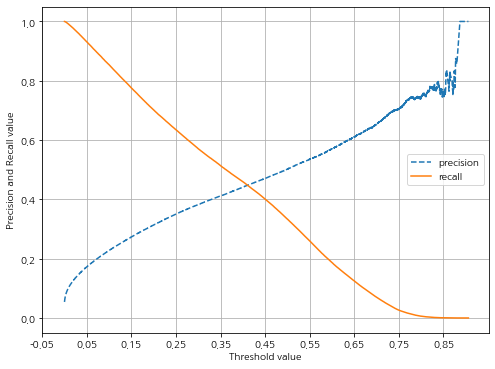

In [43]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

In [57]:
thresholds = [0.36,0.38,0.40,0.42]
pred_probas = xgb_pred_proba.reshape(-1,1)
for thres_val in thresholds:
    binarizer = Binarizer(threshold = thres_val).fit(pred_probas)
    new_pred = binarizer.transform(pred_probas)
    get_clf_eval(y_test , new_pred, pred_probas)
    print(classification_report(new_pred, y_test))

오차 행렬
[[1864184   77752]
 [  54671   56271]]
정확도: 0.9355, 정밀도: 0.4199, 재현율: 0.5072,    F1: 0.4594, AUC:0.9220
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97   1918855
         1.0       0.51      0.42      0.46    134023

    accuracy                           0.94   2052878
   macro avg       0.73      0.70      0.71   2052878
weighted avg       0.93      0.94      0.93   2052878

오차 행렬
[[1871172   70764]
 [  57202   53740]]
정확도: 0.9377, 정밀도: 0.4316, 재현율: 0.4844,    F1: 0.4565, AUC:0.9220
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97   1928374
         1.0       0.48      0.43      0.46    124504

    accuracy                           0.94   2052878
   macro avg       0.72      0.70      0.71   2052878
weighted avg       0.93      0.94      0.94   2052878

오차 행렬
[[1877739   64197]
 [  59724   51218]]
정확도: 0.9396, 정밀도: 0.4438, 재현율: 0.4617,    F1: 0.4525, AUC:0.9220
              pr

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

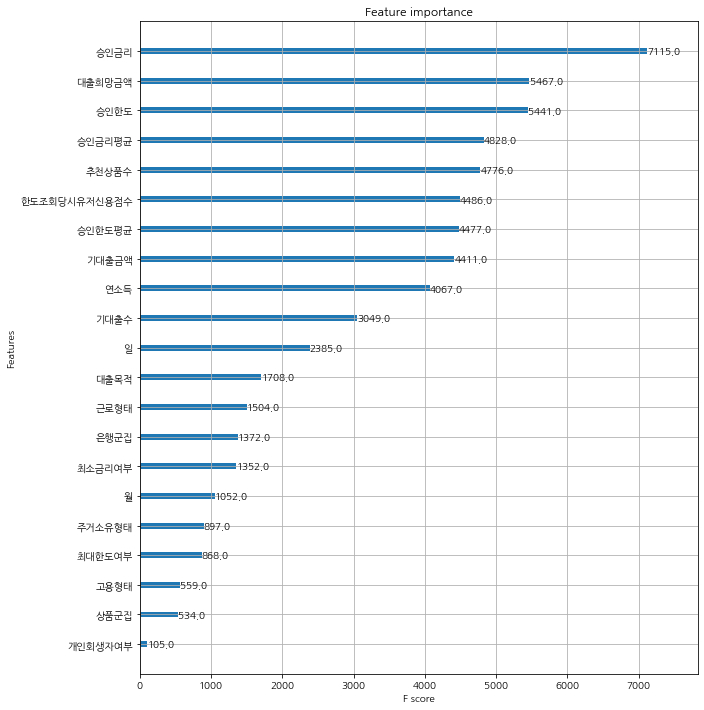

In [58]:
fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

### Scaleposweight = [1.6, 1.8, 2.0]

In [23]:
xgb_wrapper = XGBClassifier(n_estimators=300, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 1.6)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

[0]	validation_0-logloss:0.65368	validation_1-logloss:0.65372
[1]	validation_0-logloss:0.61793	validation_1-logloss:0.61800
[2]	validation_0-logloss:0.58539	validation_1-logloss:0.58549
[3]	validation_0-logloss:0.55569	validation_1-logloss:0.55582
[4]	validation_0-logloss:0.52847	validation_1-logloss:0.52863
[5]	validation_0-logloss:0.50347	validation_1-logloss:0.50365
[6]	validation_0-logloss:0.48044	validation_1-logloss:0.48064
[7]	validation_0-logloss:0.45915	validation_1-logloss:0.45937
[8]	validation_0-logloss:0.43948	validation_1-logloss:0.43972
[9]	validation_0-logloss:0.42124	validation_1-logloss:0.42151
[10]	validation_0-logloss:0.40431	validation_1-logloss:0.40459
[11]	validation_0-logloss:0.38859	validation_1-logloss:0.38889
[12]	validation_0-logloss:0.37396	validation_1-logloss:0.37428
[13]	validation_0-logloss:0.36030	validation_1-logloss:0.36064
[14]	validation_0-logloss:0.34756	validation_1-logloss:0.34792
[15]	validation_0-logloss:0.33568	validation_1-logloss:0.33605
[1

[130]	validation_0-logloss:0.14283	validation_1-logloss:0.14384
[131]	validation_0-logloss:0.14279	validation_1-logloss:0.14380
[132]	validation_0-logloss:0.14274	validation_1-logloss:0.14375
[133]	validation_0-logloss:0.14269	validation_1-logloss:0.14371
[134]	validation_0-logloss:0.14265	validation_1-logloss:0.14367
[135]	validation_0-logloss:0.14261	validation_1-logloss:0.14363
[136]	validation_0-logloss:0.14256	validation_1-logloss:0.14358
[137]	validation_0-logloss:0.14252	validation_1-logloss:0.14355
[138]	validation_0-logloss:0.14249	validation_1-logloss:0.14352
[139]	validation_0-logloss:0.14245	validation_1-logloss:0.14348
[140]	validation_0-logloss:0.14241	validation_1-logloss:0.14344
[141]	validation_0-logloss:0.14238	validation_1-logloss:0.14341
[142]	validation_0-logloss:0.14235	validation_1-logloss:0.14338
[143]	validation_0-logloss:0.14232	validation_1-logloss:0.14336
[144]	validation_0-logloss:0.14229	validation_1-logloss:0.14333
[145]	validation_0-logloss:0.14225	valid

[259]	validation_0-logloss:0.14040	validation_1-logloss:0.14169
[260]	validation_0-logloss:0.14039	validation_1-logloss:0.14168
[261]	validation_0-logloss:0.14038	validation_1-logloss:0.14167
[262]	validation_0-logloss:0.14037	validation_1-logloss:0.14167
[263]	validation_0-logloss:0.14035	validation_1-logloss:0.14165
[264]	validation_0-logloss:0.14035	validation_1-logloss:0.14165
[265]	validation_0-logloss:0.14034	validation_1-logloss:0.14164
[266]	validation_0-logloss:0.14033	validation_1-logloss:0.14163
[267]	validation_0-logloss:0.14031	validation_1-logloss:0.14162
[268]	validation_0-logloss:0.14031	validation_1-logloss:0.14162
[269]	validation_0-logloss:0.14030	validation_1-logloss:0.14161
[270]	validation_0-logloss:0.14029	validation_1-logloss:0.14160
[271]	validation_0-logloss:0.14028	validation_1-logloss:0.14159
[272]	validation_0-logloss:0.14027	validation_1-logloss:0.14159
[273]	validation_0-logloss:0.14026	validation_1-logloss:0.14158
[274]	validation_0-logloss:0.14025	valid

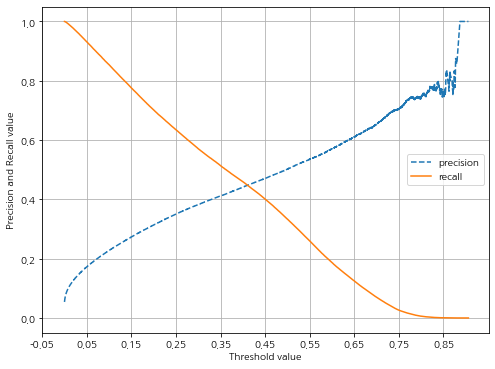

In [44]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

In [26]:
xgb_wrapper = XGBClassifier(n_estimators=300, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 1.8)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65410	validation_1-logloss:0.65414
[1]	validation_0-logloss:0.61871	validation_1-logloss:0.61878
[2]	validation_0-logloss:0.58649	validation_1-logloss:0.58659
[3]	validation_0-logloss:0.55706	validation_1-logloss:0.55719
[4]	validation_0-logloss:0.53010	validation_1-logloss:0.53026
[5]	validation_0-logloss:0.50530	validation_1-logloss:0.50549
[6]	validation_0-logloss:0.48247	validation_1-logloss:0.48269
[7]	validation_0-logloss:0.46137	validation_1-logloss:0.46161
[8]	validation_0-logloss:0.44185	validation_1-logloss:0.44211
[9]	validation_0-logloss:0.42376	validation_1-logloss:0.42404
[10]	validation_0-logloss:0.40696	validation_1-logloss:0.40725
[11]	validation_0-logloss:0.39135	validation_1-logloss:0.39167
[12]	validation_0-logloss:0.37679	validation_1-logloss:0.37713
[13]	validation_0-logloss:0.36322	validation_1-logloss:0.36357
[14]	validation_0-logloss:0.35059	validation_1-logloss:0.35096
[15]	validation_0-logloss:0.33877	validation_1-logloss:0.33916
[1

[130]	validation_0-logloss:0.14558	validation_1-logloss:0.14662
[131]	validation_0-logloss:0.14553	validation_1-logloss:0.14657
[132]	validation_0-logloss:0.14549	validation_1-logloss:0.14653
[133]	validation_0-logloss:0.14543	validation_1-logloss:0.14647
[134]	validation_0-logloss:0.14539	validation_1-logloss:0.14644
[135]	validation_0-logloss:0.14535	validation_1-logloss:0.14640
[136]	validation_0-logloss:0.14531	validation_1-logloss:0.14636
[137]	validation_0-logloss:0.14527	validation_1-logloss:0.14632
[138]	validation_0-logloss:0.14522	validation_1-logloss:0.14627
[139]	validation_0-logloss:0.14519	validation_1-logloss:0.14624
[140]	validation_0-logloss:0.14516	validation_1-logloss:0.14622
[141]	validation_0-logloss:0.14513	validation_1-logloss:0.14619
[142]	validation_0-logloss:0.14509	validation_1-logloss:0.14615
[143]	validation_0-logloss:0.14506	validation_1-logloss:0.14612
[144]	validation_0-logloss:0.14503	validation_1-logloss:0.14609
[145]	validation_0-logloss:0.14500	valid

[259]	validation_0-logloss:0.14318	validation_1-logloss:0.14452
[260]	validation_0-logloss:0.14317	validation_1-logloss:0.14450
[261]	validation_0-logloss:0.14316	validation_1-logloss:0.14450
[262]	validation_0-logloss:0.14314	validation_1-logloss:0.14449
[263]	validation_0-logloss:0.14314	validation_1-logloss:0.14448
[264]	validation_0-logloss:0.14313	validation_1-logloss:0.14448
[265]	validation_0-logloss:0.14312	validation_1-logloss:0.14447
[266]	validation_0-logloss:0.14311	validation_1-logloss:0.14446
[267]	validation_0-logloss:0.14310	validation_1-logloss:0.14445
[268]	validation_0-logloss:0.14308	validation_1-logloss:0.14443
[269]	validation_0-logloss:0.14307	validation_1-logloss:0.14442
[270]	validation_0-logloss:0.14305	validation_1-logloss:0.14441
[271]	validation_0-logloss:0.14304	validation_1-logloss:0.14440
[272]	validation_0-logloss:0.14304	validation_1-logloss:0.14440
[273]	validation_0-logloss:0.14302	validation_1-logloss:0.14439
[274]	validation_0-logloss:0.14301	valid

In [27]:
get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

오차 행렬
[[1897556   44380]
 [  70407   40535]]
정확도: 0.9441, 정밀도: 0.4774, 재현율: 0.3654,    F1: 0.4139, AUC:0.9147


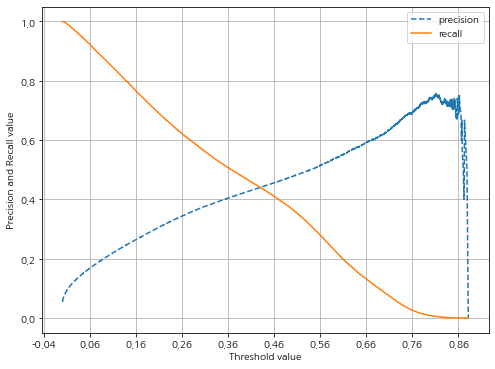

In [28]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

In [29]:
xgb_wrapper = XGBClassifier(n_estimators=300, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 2)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65450	validation_1-logloss:0.65454
[1]	validation_0-logloss:0.61945	validation_1-logloss:0.61953
[2]	validation_0-logloss:0.58756	validation_1-logloss:0.58767
[3]	validation_0-logloss:0.55840	validation_1-logloss:0.55854
[4]	validation_0-logloss:0.53169	validation_1-logloss:0.53186
[5]	validation_0-logloss:0.50712	validation_1-logloss:0.50732
[6]	validation_0-logloss:0.48445	validation_1-logloss:0.48467
[7]	validation_0-logloss:0.46354	validation_1-logloss:0.46379
[8]	validation_0-logloss:0.44420	validation_1-logloss:0.44448
[9]	validation_0-logloss:0.42624	validation_1-logloss:0.42653
[10]	validation_0-logloss:0.40957	validation_1-logloss:0.40989
[11]	validation_0-logloss:0.39407	validation_1-logloss:0.39440
[12]	validation_0-logloss:0.37962	validation_1-logloss:0.37998
[13]	validation_0-logloss:0.36616	validation_1-logloss:0.36654
[14]	validation_0-logloss:0.35359	validation_1-logloss:0.35399
[15]	validation_0-logloss:0.34186	validation_1-logloss:0.34227
[1

[130]	validation_0-logloss:0.14874	validation_1-logloss:0.14979
[131]	validation_0-logloss:0.14869	validation_1-logloss:0.14975
[132]	validation_0-logloss:0.14865	validation_1-logloss:0.14971
[133]	validation_0-logloss:0.14860	validation_1-logloss:0.14966
[134]	validation_0-logloss:0.14856	validation_1-logloss:0.14962
[135]	validation_0-logloss:0.14850	validation_1-logloss:0.14956
[136]	validation_0-logloss:0.14845	validation_1-logloss:0.14951
[137]	validation_0-logloss:0.14841	validation_1-logloss:0.14948
[138]	validation_0-logloss:0.14838	validation_1-logloss:0.14945
[139]	validation_0-logloss:0.14834	validation_1-logloss:0.14941
[140]	validation_0-logloss:0.14831	validation_1-logloss:0.14938
[141]	validation_0-logloss:0.14826	validation_1-logloss:0.14934
[142]	validation_0-logloss:0.14823	validation_1-logloss:0.14931
[143]	validation_0-logloss:0.14820	validation_1-logloss:0.14928
[144]	validation_0-logloss:0.14815	validation_1-logloss:0.14924
[145]	validation_0-logloss:0.14812	valid

[259]	validation_0-logloss:0.14627	validation_1-logloss:0.14759
[260]	validation_0-logloss:0.14626	validation_1-logloss:0.14759
[261]	validation_0-logloss:0.14625	validation_1-logloss:0.14758
[262]	validation_0-logloss:0.14624	validation_1-logloss:0.14757
[263]	validation_0-logloss:0.14623	validation_1-logloss:0.14757
[264]	validation_0-logloss:0.14623	validation_1-logloss:0.14756
[265]	validation_0-logloss:0.14622	validation_1-logloss:0.14756
[266]	validation_0-logloss:0.14621	validation_1-logloss:0.14756
[267]	validation_0-logloss:0.14619	validation_1-logloss:0.14754
[268]	validation_0-logloss:0.14618	validation_1-logloss:0.14753
[269]	validation_0-logloss:0.14618	validation_1-logloss:0.14753
[270]	validation_0-logloss:0.14617	validation_1-logloss:0.14752
[271]	validation_0-logloss:0.14617	validation_1-logloss:0.14752
[272]	validation_0-logloss:0.14615	validation_1-logloss:0.14751
[273]	validation_0-logloss:0.14615	validation_1-logloss:0.14751
[274]	validation_0-logloss:0.14614	valid

In [30]:
get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

오차 행렬
[[1891028   50908]
 [  66993   43949]]
정확도: 0.9426, 정밀도: 0.4633, 재현율: 0.3961,    F1: 0.4271, AUC:0.9147


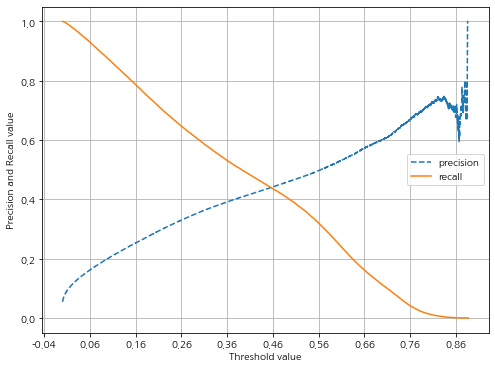

In [31]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

## n_estimator

In [24]:
xgb_wrapper = XGBClassifier(n_estimators=500, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 1.6)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

[0]	validation_0-logloss:0.65368	validation_1-logloss:0.65372
[1]	validation_0-logloss:0.61793	validation_1-logloss:0.61800
[2]	validation_0-logloss:0.58539	validation_1-logloss:0.58549
[3]	validation_0-logloss:0.55569	validation_1-logloss:0.55582
[4]	validation_0-logloss:0.52847	validation_1-logloss:0.52863
[5]	validation_0-logloss:0.50347	validation_1-logloss:0.50365
[6]	validation_0-logloss:0.48044	validation_1-logloss:0.48064
[7]	validation_0-logloss:0.45915	validation_1-logloss:0.45937
[8]	validation_0-logloss:0.43948	validation_1-logloss:0.43972
[9]	validation_0-logloss:0.42124	validation_1-logloss:0.42151
[10]	validation_0-logloss:0.40431	validation_1-logloss:0.40459
[11]	validation_0-logloss:0.38859	validation_1-logloss:0.38889
[12]	validation_0-logloss:0.37396	validation_1-logloss:0.37428
[13]	validation_0-logloss:0.36030	validation_1-logloss:0.36064
[14]	validation_0-logloss:0.34756	validation_1-logloss:0.34792
[15]	validation_0-logloss:0.33568	validation_1-logloss:0.33605
[1

[130]	validation_0-logloss:0.14283	validation_1-logloss:0.14384
[131]	validation_0-logloss:0.14279	validation_1-logloss:0.14380
[132]	validation_0-logloss:0.14274	validation_1-logloss:0.14375
[133]	validation_0-logloss:0.14269	validation_1-logloss:0.14371
[134]	validation_0-logloss:0.14265	validation_1-logloss:0.14367
[135]	validation_0-logloss:0.14261	validation_1-logloss:0.14363
[136]	validation_0-logloss:0.14256	validation_1-logloss:0.14358
[137]	validation_0-logloss:0.14252	validation_1-logloss:0.14355
[138]	validation_0-logloss:0.14249	validation_1-logloss:0.14352
[139]	validation_0-logloss:0.14245	validation_1-logloss:0.14348
[140]	validation_0-logloss:0.14241	validation_1-logloss:0.14344
[141]	validation_0-logloss:0.14238	validation_1-logloss:0.14341
[142]	validation_0-logloss:0.14235	validation_1-logloss:0.14338
[143]	validation_0-logloss:0.14232	validation_1-logloss:0.14336
[144]	validation_0-logloss:0.14229	validation_1-logloss:0.14333
[145]	validation_0-logloss:0.14225	valid

[259]	validation_0-logloss:0.14040	validation_1-logloss:0.14169
[260]	validation_0-logloss:0.14039	validation_1-logloss:0.14168
[261]	validation_0-logloss:0.14038	validation_1-logloss:0.14167
[262]	validation_0-logloss:0.14037	validation_1-logloss:0.14167
[263]	validation_0-logloss:0.14035	validation_1-logloss:0.14165
[264]	validation_0-logloss:0.14035	validation_1-logloss:0.14165
[265]	validation_0-logloss:0.14034	validation_1-logloss:0.14164
[266]	validation_0-logloss:0.14033	validation_1-logloss:0.14163
[267]	validation_0-logloss:0.14031	validation_1-logloss:0.14162
[268]	validation_0-logloss:0.14031	validation_1-logloss:0.14162
[269]	validation_0-logloss:0.14030	validation_1-logloss:0.14161
[270]	validation_0-logloss:0.14029	validation_1-logloss:0.14160
[271]	validation_0-logloss:0.14028	validation_1-logloss:0.14159
[272]	validation_0-logloss:0.14027	validation_1-logloss:0.14159
[273]	validation_0-logloss:0.14026	validation_1-logloss:0.14158
[274]	validation_0-logloss:0.14025	valid

[388]	validation_0-logloss:0.13934	validation_1-logloss:0.14089
[389]	validation_0-logloss:0.13933	validation_1-logloss:0.14088
[390]	validation_0-logloss:0.13932	validation_1-logloss:0.14088
[391]	validation_0-logloss:0.13931	validation_1-logloss:0.14087
[392]	validation_0-logloss:0.13930	validation_1-logloss:0.14087
[393]	validation_0-logloss:0.13930	validation_1-logloss:0.14086
[394]	validation_0-logloss:0.13930	validation_1-logloss:0.14086
[395]	validation_0-logloss:0.13929	validation_1-logloss:0.14086
[396]	validation_0-logloss:0.13929	validation_1-logloss:0.14086
[397]	validation_0-logloss:0.13928	validation_1-logloss:0.14085
[398]	validation_0-logloss:0.13928	validation_1-logloss:0.14085
[399]	validation_0-logloss:0.13927	validation_1-logloss:0.14085
[400]	validation_0-logloss:0.13926	validation_1-logloss:0.14084
[401]	validation_0-logloss:0.13926	validation_1-logloss:0.14084
[402]	validation_0-logloss:0.13926	validation_1-logloss:0.14084
[403]	validation_0-logloss:0.13925	valid

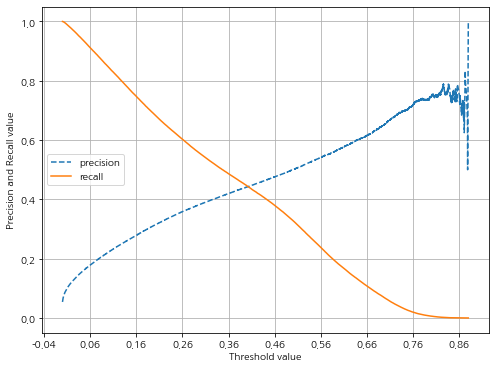

In [25]:
precision_recall_curve_plot(y_test, xgb_pred_proba)

In [26]:
thresholds = [0.36,0.37,0.38,0.39,0.40,0.41,0.42]
pred_probas = xgb_pred_proba.reshape(-1,1)
for thres_val in thresholds:
    binarizer = Binarizer(threshold = thres_val).fit(pred_probas)
    new_pred = binarizer.transform(pred_probas)
    get_clf_eval(y_test , new_pred, pred_probas)
    #print(classification_report(new_pred, y_test))

오차 행렬
[[1867278   74658]
 [  56970   53972]]
정확도: 0.9359, 정밀도: 0.4196, 재현율: 0.4865,    F1: 0.4506, AUC:0.9164
오차 행렬
[[1870450   71486]
 [  58052   52890]]
정확도: 0.9369, 정밀도: 0.4252, 재현율: 0.4767,    F1: 0.4495, AUC:0.9164
오차 행렬
[[1873659   68277]
 [  59208   51734]]
정확도: 0.9379, 정밀도: 0.4311, 재현율: 0.4663,    F1: 0.4480, AUC:0.9164
오차 행렬
[[1876591   65345]
 [  60336   50606]]
정확도: 0.9388, 정밀도: 0.4364, 재현율: 0.4561,    F1: 0.4461, AUC:0.9164
오차 행렬
[[1879454   62482]
 [  61491   49451]]
정확도: 0.9396, 정밀도: 0.4418, 재현율: 0.4457,    F1: 0.4438, AUC:0.9164
오차 행렬
[[1882324   59612]
 [  62714   48228]]
정확도: 0.9404, 정밀도: 0.4472, 재현율: 0.4347,    F1: 0.4409, AUC:0.9164
오차 행렬
[[1885075   56861]
 [  63853   47089]]
정확도: 0.9412, 정밀도: 0.4530, 재현율: 0.4244,    F1: 0.4383, AUC:0.9164


## learning_rate

In [27]:
xgb_wrapper = XGBClassifier(n_estimators=500, learning_rate=0.03, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 1.6)
evals = [(X_tr, y_tr), (X_val, y_val)]


xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

xgb_preds = xgb_wrapper.predict(X_test)
xgb_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, xgb_preds, xgb_pred_proba)

[0]	validation_0-logloss:0.66923	validation_1-logloss:0.66926
[1]	validation_0-logloss:0.64670	validation_1-logloss:0.64674
[2]	validation_0-logloss:0.62542	validation_1-logloss:0.62549
[3]	validation_0-logloss:0.60530	validation_1-logloss:0.60539
[4]	validation_0-logloss:0.58627	validation_1-logloss:0.58637
[5]	validation_0-logloss:0.56822	validation_1-logloss:0.56834
[6]	validation_0-logloss:0.55110	validation_1-logloss:0.55124
[7]	validation_0-logloss:0.53484	validation_1-logloss:0.53499
[8]	validation_0-logloss:0.51937	validation_1-logloss:0.51954
[9]	validation_0-logloss:0.50466	validation_1-logloss:0.50484
[10]	validation_0-logloss:0.49065	validation_1-logloss:0.49085
[11]	validation_0-logloss:0.47729	validation_1-logloss:0.47750
[12]	validation_0-logloss:0.46454	validation_1-logloss:0.46476
[13]	validation_0-logloss:0.45238	validation_1-logloss:0.45262
[14]	validation_0-logloss:0.44078	validation_1-logloss:0.44102
[15]	validation_0-logloss:0.42967	validation_1-logloss:0.42992
[1

[130]	validation_0-logloss:0.15046	validation_1-logloss:0.15130
[131]	validation_0-logloss:0.15024	validation_1-logloss:0.15108
[132]	validation_0-logloss:0.15003	validation_1-logloss:0.15087
[133]	validation_0-logloss:0.14982	validation_1-logloss:0.15067
[134]	validation_0-logloss:0.14962	validation_1-logloss:0.15047
[135]	validation_0-logloss:0.14942	validation_1-logloss:0.15027
[136]	validation_0-logloss:0.14923	validation_1-logloss:0.15009
[137]	validation_0-logloss:0.14905	validation_1-logloss:0.14991
[138]	validation_0-logloss:0.14888	validation_1-logloss:0.14973
[139]	validation_0-logloss:0.14870	validation_1-logloss:0.14956
[140]	validation_0-logloss:0.14854	validation_1-logloss:0.14940
[141]	validation_0-logloss:0.14838	validation_1-logloss:0.14924
[142]	validation_0-logloss:0.14822	validation_1-logloss:0.14909
[143]	validation_0-logloss:0.14808	validation_1-logloss:0.14895
[144]	validation_0-logloss:0.14793	validation_1-logloss:0.14880
[145]	validation_0-logloss:0.14778	valid

[259]	validation_0-logloss:0.14195	validation_1-logloss:0.14301
[260]	validation_0-logloss:0.14193	validation_1-logloss:0.14299
[261]	validation_0-logloss:0.14192	validation_1-logloss:0.14298
[262]	validation_0-logloss:0.14190	validation_1-logloss:0.14296
[263]	validation_0-logloss:0.14188	validation_1-logloss:0.14294
[264]	validation_0-logloss:0.14187	validation_1-logloss:0.14293
[265]	validation_0-logloss:0.14185	validation_1-logloss:0.14291
[266]	validation_0-logloss:0.14184	validation_1-logloss:0.14290
[267]	validation_0-logloss:0.14182	validation_1-logloss:0.14288
[268]	validation_0-logloss:0.14181	validation_1-logloss:0.14287
[269]	validation_0-logloss:0.14179	validation_1-logloss:0.14286
[270]	validation_0-logloss:0.14178	validation_1-logloss:0.14284
[271]	validation_0-logloss:0.14177	validation_1-logloss:0.14283
[272]	validation_0-logloss:0.14175	validation_1-logloss:0.14282
[273]	validation_0-logloss:0.14174	validation_1-logloss:0.14281
[274]	validation_0-logloss:0.14173	valid

[388]	validation_0-logloss:0.14071	validation_1-logloss:0.14194
[389]	validation_0-logloss:0.14071	validation_1-logloss:0.14193
[390]	validation_0-logloss:0.14070	validation_1-logloss:0.14193
[391]	validation_0-logloss:0.14070	validation_1-logloss:0.14193
[392]	validation_0-logloss:0.14069	validation_1-logloss:0.14192
[393]	validation_0-logloss:0.14068	validation_1-logloss:0.14191
[394]	validation_0-logloss:0.14068	validation_1-logloss:0.14191
[395]	validation_0-logloss:0.14067	validation_1-logloss:0.14190
[396]	validation_0-logloss:0.14066	validation_1-logloss:0.14189
[397]	validation_0-logloss:0.14065	validation_1-logloss:0.14188
[398]	validation_0-logloss:0.14064	validation_1-logloss:0.14188
[399]	validation_0-logloss:0.14064	validation_1-logloss:0.14188
[400]	validation_0-logloss:0.14064	validation_1-logloss:0.14188
[401]	validation_0-logloss:0.14063	validation_1-logloss:0.14187
[402]	validation_0-logloss:0.14063	validation_1-logloss:0.14187
[403]	validation_0-logloss:0.14062	valid

In [36]:
evals = [(X_tr, y_tr), (X_val, y_val)]

xgb_wrapper = XGBClassifier(n_estimators=300, learning_rate=0.05, tree_method ='gpu_hist',
          predictor = 'gpu_predictor', scale_pos_weight = 2)

In [37]:
parameters = {'scale_pos_weight': [1.6, 1.8, 2.0, 2.2]}

In [38]:
grid_xgb = GridSearchCV(xgb_wrapper, param_grid = parameters, cv =5, refit = True)